## Importando Bibliotecas ##

In [2]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns

# add root to sys.path
# a
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [3]:
from data.generate_data import generate

## Adquirindo os Dados ##

### Através do Scrapping no site da Defesa Civíl de Rio do Sul e da API Open-Meteo foram adquiridos os dados relacionados as enchentes a partir de 2019-01-01 até 2024-12-31 ###

In [4]:
train_df = generate(
    start_date="2019-01-01",
    end_date="2024-12-31",
    type="train",
    save=False
)

2025-05-01 01:18:52.656 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-05-01 01:18:52.656 | INFO     | data.generate_data:__init__:31 - DataGenerator initialized with output directory: c:\Users\destr\OneDrive\Documentos\Enchentes\data\output
2025-05-01 01:18:52.656 | INFO     | data.generate_data:generate:170 - Generating train dataset from 2019-01-01 to 2024-12-31
2025-05-01 01:18:52.656 | INFO     | data.generate_data:_get_weather_data:44 - Fetching weather data from 2019-01-01 to 2024-12-31
2025-05-01 01:18:56.723 | INFO     | data.generate_data:_get_weather_data:48 - Weather data fetched successfully: (52608, 4) rows
2025-05-01 01:18:56.723 | INFO     | data.generate_data:_get_water_level_data:65 - Scraping water level data from 2019-01-01 to 2024-12-31
2025-05-01 01:18:56.723 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2019-01-01 até 2024-12-31
2025-05-01 01:18:56.723 | INFO     | data.scraping:parse_data:30 - Serão processados 7

Processando intervalos:   0%|          | 0/731 [00:00<?, ?it/s]

2025-05-01 01:20:39.915 | WARNING  | data.scraping:parse_data:42 - Intervalo de datas vazio encontrado, pulando
2025-05-01 01:20:39.916 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-05-01 01:20:40.030 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (35747, 2)
2025-05-01 01:20:40.030 | INFO     | data.generate_data:_get_water_level_data:68 - Water level data scraped successfully: (35747, 2) rows
2025-05-01 01:20:40.063 | INFO     | data.generate_data:_merge_datasets:106 - Datasets merged successfully: (52608, 6) rows
2025-05-01 01:20:40.096 | INFO     | data.generate_data:_process_data:145 - Data processing completed: (52537, 17) rows


In [5]:
print(train_df)

                     time  temperature_2m  relative_humidity_2m  \
47    2019-01-02 23:00:00            25.6                    91   
48    2019-01-03 00:00:00            24.5                    96   
49    2019-01-03 01:00:00            24.3                    97   
50    2019-01-03 02:00:00            24.1                    98   
51    2019-01-03 03:00:00            24.0                    99   
...                   ...             ...                   ...   
52579 2024-12-30 19:00:00            21.6                    86   
52580 2024-12-30 20:00:00            21.2                    88   
52581 2024-12-30 21:00:00            20.7                    89   
52582 2024-12-30 22:00:00            21.0                    88   
52583 2024-12-30 23:00:00            20.6                    89   

       apparent_temperature  rain  water_level  hour  day_of_week  month  \
47                     30.6   0.0         1.08    23            2      1   
48                     29.8   0.0         1

## EDA ##
### 1. Através da média do nível do rio de cada mês desde 2019 até 2024, foi possível se analisar através de gráficos de barra quais foram os mêses que mais houveram um nível alto do rio ###

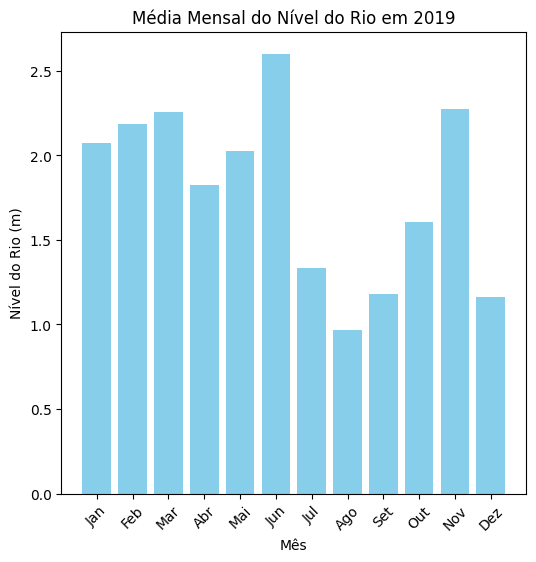

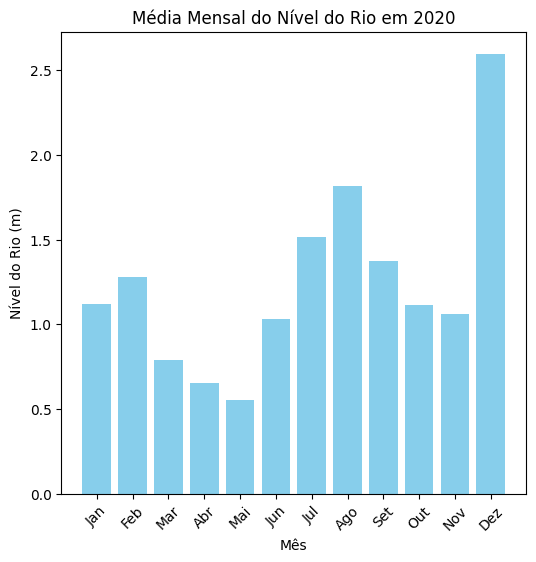

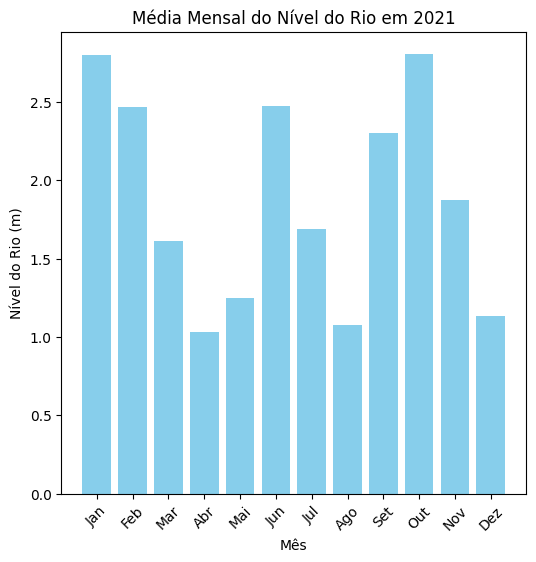

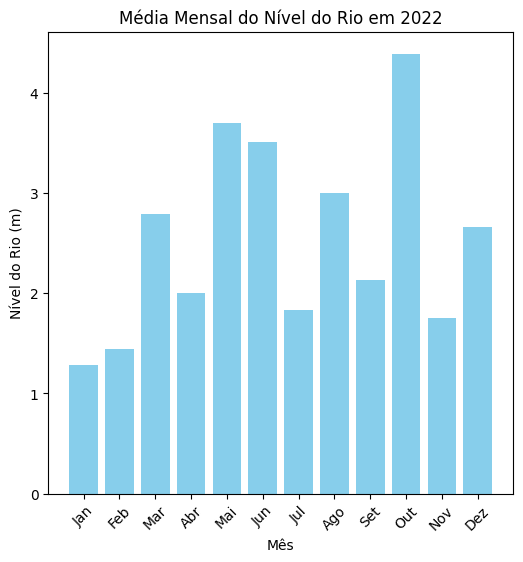

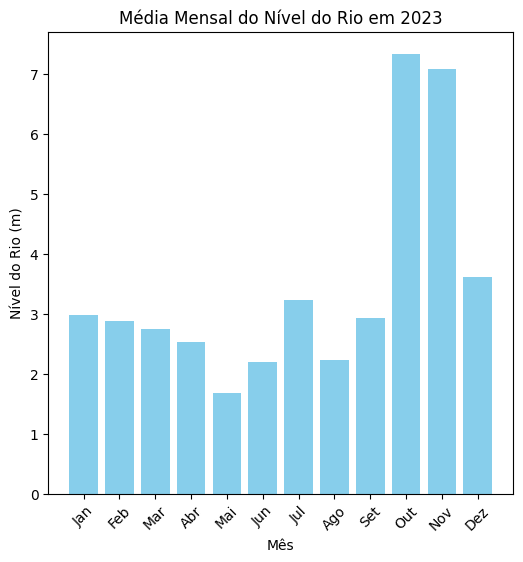

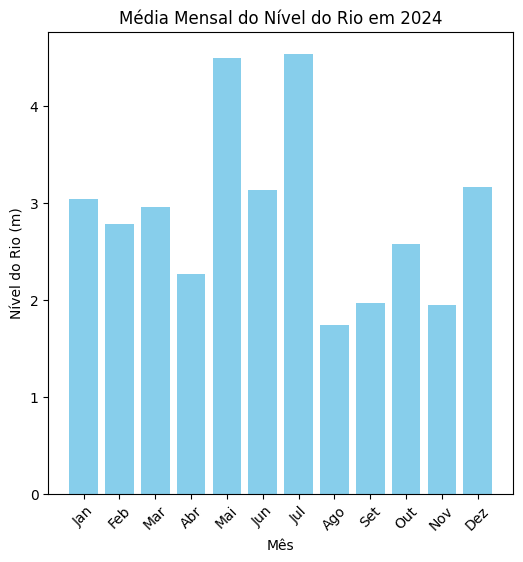

In [6]:
def month_set(ano):
    year_df = train_df[train_df['time'].dt.year == ano].copy()
    year_df['mes'] = year_df['time'].dt.month
    media_ano = year_df.groupby('mes')['water_level'].mean().reset_index()
    return media_ano

def plot_month(ano, media_ano):
    plt.bar(media_ano['mes'], media_ano['water_level'], color='skyblue')
    plt.xlabel('Mês')
    plt.ylabel('Nível do Rio (m)')
    plt.title(f'Média Mensal do Nível do Rio em {ano}')
    plt.xticks(media_ano['mes'], 
               ['Jan', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 
                'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(6, 6)
    plt.show()

def loop_func(ano_inicial):
    if ano_inicial == 2019:
        while ano_inicial <= 2024:
            media = month_set(ano_inicial)
            plot_month(ano_inicial, media)
            ano_inicial += 1
    else:
        print("Erro: ano inicial deve ser 2019")
loop_func(2019)

### 2. Após descobrir os mêses que mais houveram um número maior na média do nível do rio, foi necessário analisar tais mêses para descobrir as features que influenciavam o aumento do nível do rio ###
exemplo:

In [7]:
month_df = train_df[train_df['time'].dt.year == 2023]
month_df['mes'] = month_df['time'].dt.month
month_df = month_df.loc[month_df['mes'] == 10]
month_df['dia'] = month_df['time'].dt.day
day_df = month_df.groupby('dia')['water_level'].mean().reset_index()
#mean_month = month_df.groupby('mes')['water_level'].mean().reset_index()
day_df

C:\Users\destr\AppData\Local\Temp\ipykernel_13248\1415852259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['mes'] = month_df['time'].dt.month


,dia,water_level
0,1,4.055833
1,2,4.231250
2,3,3.728333
3,4,5.586667
4,5,7.849167
5,6,6.996250
6,7,7.842083
7,8,9.907292
8,9,10.775000
9,10,10.532917


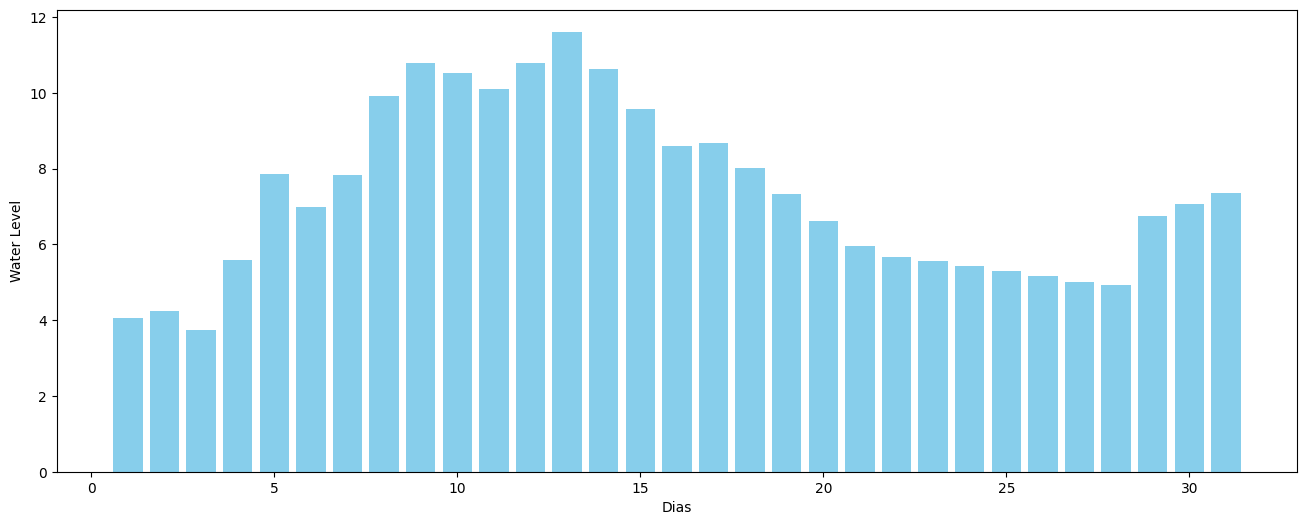

In [8]:
plt.bar(day_df['dia'], day_df['water_level'], color='skyblue')
plt.ylabel('Water Level')
plt.xlabel('Dias')
plt.gcf().set_size_inches(16, 6)
plt.show()

In [9]:
month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29'])]

C:\Users\destr\AppData\Local\Temp\ipykernel_13248\121827600.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29'])]


,time,temperature_2m,relative_humidity_2m,apparent_temperature,rain,water_level,hour,day_of_week,month,rain_24h,temperature_24h_avg,humidity_24h_avg,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h,mes,dia
41616,2023-10-01,18.0,100,19.8,0.4,3.98,0,6,10,15.7,18.966667,90.083333,4.00,4.040000,4.050000,3.980,4.26,10,1
41640,2023-10-02,16.1,85,15.6,0.0,4.26,0,0,10,0.4,19.679167,83.000000,4.26,4.254545,4.246364,4.230,4.20,10,2
41664,2023-10-03,14.2,75,13.1,0.0,4.20,0,1,10,0.0,17.337500,80.041667,4.19,4.150000,4.070000,3.770,2.95,10,3
41688,2023-10-04,17.1,89,18.3,0.0,2.95,0,2,10,0.0,18.304167,74.958333,2.91,2.830000,3.030000,6.100,8.29,10,4
41712,2023-10-05,17.2,100,19.0,0.0,8.29,0,3,10,38.8,17.579167,96.708333,8.29,8.206364,8.080909,7.830,7.37,10,5
41736,2023-10-06,15.8,90,16.4,0.0,7.37,0,4,10,1.0,18.491667,88.500000,7.34,7.270000,7.190000,6.920,6.63,10,6
41760,2023-10-07,18.7,97,21.3,1.0,6.63,0,5,10,5.4,18.850000,90.291667,6.62,6.580000,6.540000,7.790,9.50,10,7
41784,2023-10-08,18.1,98,20.3,0.1,9.50,0,6,10,27.6,19.779167,95.166667,9.50,9.577273,9.693182,9.925,10.35,10,8
41808,2023-10-09,15.8,100,17.1,0.0,10.35,0,0,10,64.6,17.275000,99.500000,10.43,10.580000,10.750000,10.890,10.82,10,9
41832,2023-10-10,16.9,89,17.1,0.0,10.82,0,1,10,0.9,18.837500,83.291667,10.80,10.760000,10.690000,10.510,10.29,10,10


### 3. Assim como nos outras situações de enchentes analisadas, foi encontrado os seguintes padrões: ###
#### a) temperature_2m = variando entre 13°C a 23.1°C (mais comum ser 19°C) ou 6.2°C a 15.9°C ####
#### b) relative_humidity_2m = variando entre 88% a 100% ou 75% a 100%, sendo +90% quase certeza a vinda de uma chuva ####
#### c) rain = variando entre 1.0mm a 4.1mm, geralmente havendo uma constância/"acûmulo" em 0.X ####
#### *d) rain_24h = variando entre 12.5mm a 64.6mm, representando que quanto maior for o seu valor, maior será magnificiência da enchente, ou seja, maior o valor no nível do rio ####

### 4. Correlação ###
#### Para que seja possível aprimorar ainda mais o resultado da previsão foi feito um estudo das correlações ####

In [10]:
features = month_df.loc[:, ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h', 'water_level_next_24h', 'water_level_next_6h']]
features_df = pd.DataFrame(data=features)
features_df.corr()

,temperature_2m,relative_humidity_2m,apparent_temperature,rain_24h,temperature_24h_avg,humidity_24h_avg,water_level_next_3h,water_level_next_24h,water_level_next_6h
temperature_2m,1.000000,-0.549074,0.970498,0.069616,0.583212,-0.032232,-0.232308,-0.165852,-0.226376
relative_humidity_2m,-0.549074,1.000000,-0.380238,0.364605,0.016891,0.459531,0.151534,0.242242,0.174190
apparent_temperature,0.970498,-0.380238,1.000000,0.184961,0.645059,0.080669,-0.221597,-0.129162,-0.209380
rain_24h,0.069616,0.364605,0.184961,1.000000,0.079959,0.757017,0.243957,0.278680,0.264234
temperature_24h_avg,0.583212,0.016891,0.645059,0.079959,1.000000,-0.052457,-0.314356,-0.268301,-0.298883
humidity_24h_avg,-0.032232,0.459531,0.080669,0.757017,-0.052457,1.000000,0.374287,0.338751,0.388825
water_level_next_3h,-0.232308,0.151534,-0.221597,0.243957,-0.314356,0.374287,1.000000,0.877482,0.994864
water_level_next_24h,-0.165852,0.242242,-0.129162,0.278680,-0.268301,0.338751,0.877482,1.000000,0.897005
water_level_next_6h,-0.226376,0.174190,-0.209380,0.264234,-0.298883,0.388825,0.994864,0.897005,1.000000


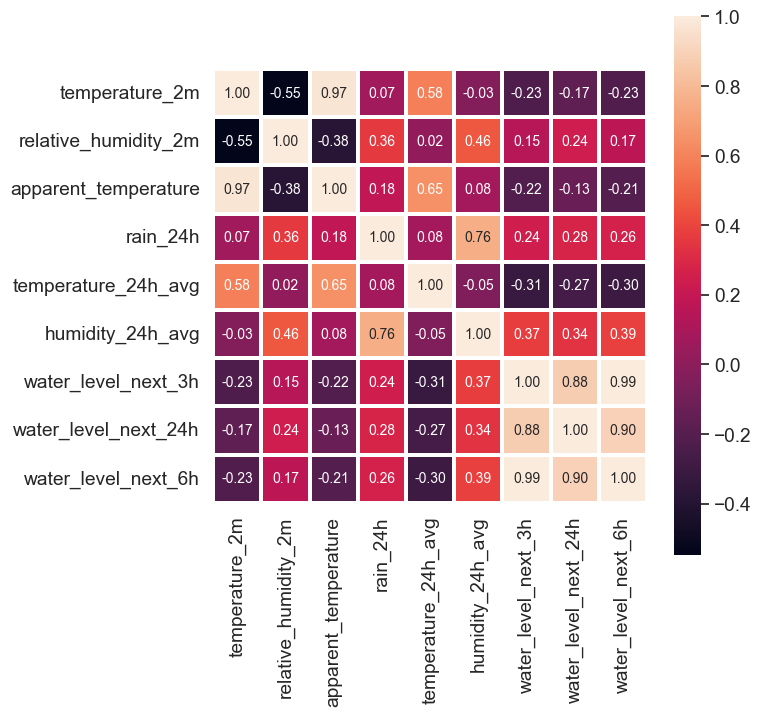

In [11]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(features_df.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=features_df.columns , xticklabels=features_df.columns
            )
plt.show()

### Modelos básicos de regressão do Scikit-learn e comparação de resultados ###
**Serão testados os seguintes modelos:**

LinearRegression

Ridge

Lasso

Elastic Net

Stochastic Gradient Descent

DecisionTreeRegressor

RandomForestRegressor

SVR

GXBoost

LinearRegression

In [12]:
from sklearn.linear_model import LinearRegression
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mliearn = LinearRegression()
mliearn.fit(X_train, y_train)
y_pred = mliearn.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 1.0696770514495044
R² (coeficiente de determinação): 0.7641154931343134


Rigde

In [13]:
from sklearn.linear_model import Ridge
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mridge = Ridge(alpha=1.0)
mridge.fit(X_train, y_train)
y_pred = mridge.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 1.0695721321765654
R² (coeficiente de determinação): 0.7641386298660254


Lasso

In [14]:
from sklearn.linear_model import Lasso
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlasso = Lasso(alpha=0.1)
mlasso.fit(X_train, y_train)
y_pred = mlasso.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 1.1372681415480441
R² (coeficiente de determinação): 0.7492103486939394


Elastic net

In [15]:
from sklearn.linear_model import ElasticNet
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
modelo_elastic.fit(X_train, y_train)
y_pred = modelo_elastic.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 1.0939581747191685
R² (coeficiente de determinação): 0.7587610351875449


Stochastic Gradient Descent


In [16]:
from sklearn.linear_model import SGDRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_sgd = SGDRegressor(
penalty='l2',        # 'l2' = Ridge, 'l1' = Lasso, 'elasticnet' = ambos
alpha=0.001,         # força da regularização
max_iter=1000,       # número máximo de iterações
tol=1e-3,            # tolerância pro critério de parada
random_state=42
)
modelo_sgd.fit(X_train, y_train)
y_pred = modelo_sgd.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 9.787746688677704e+24
R² (coeficiente de determinação): -2.1583877095020452e+24


DecisionTreeRegressor


In [17]:
from sklearn.tree import DecisionTreeRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_arvore = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo_arvore.fit(X_train, y_train)
y_pred = modelo_arvore.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Erro médio quadrático (MSE): 0.5083534285361182
R² (coeficiente de determinação): 0.8878982234486276


RandomForestRegressor

In [61]:
import joblib
from sklearn.ensemble import RandomForestRegressor
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain_24h', 'humidity_24h_avg']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_floresta = RandomForestRegressor(random_state=42, n_estimators=100)
modelo_floresta.fit(X_train, y_train)
y_pred = modelo_floresta.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))
joblib.dump(modelo_floresta, 'modelo_random_forest.pkl')
print('Modelo salvo como modelo_random_forest.pkl')

Erro médio quadrático (MSE): 1.5643917134254823
R² (coeficiente de determinação): 0.6550213287589106
Modelo salvo como modelo_random_forest.pkl


SVR

In [ ]:
from sklearn.svm import SVR
X = features_df[['temperature_2m', 'relative_humidity_2m', 'rain', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg']]
y = features_df['water_level_next_24h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_svr = SVR(kernel='rbf')
modelo_svr.fit(X_train, y_train)
y_pred = modelo_svr.predict(X_test)
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

XGBOOST

In [19]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json

# Modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Definição do grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Busca aleatória
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Treinamento com os melhores parâmetros
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Salvando modelo
best_model.save_model("modelo_salvo1.json")

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Melhores parâmetros encontrados:", random_search.best_params_)
print(f"RMSE no conjunto de teste: {rmse:.2f}")
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores parâmetros encontrados: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
RMSE no conjunto de teste: 0.03
Erro médio quadrático (MSE): 0.0006285986416357333
R² (coeficiente de determinação): 0.9998862413701409


### Resultado: XGBoost ###

### Previsão e Resultado ###
#### Escolhendo uma data, houve um teste de resultado para saber a proximidade da previsão com o resultado verdadeiro a partir do XGBoost ####

In [20]:
predict_df = generate(
    start_date="2025-04-20",
    end_date="2025-04-28",
    type="train",
    save=False
)

2025-05-01 01:38:07.204 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-05-01 01:38:07.204 | INFO     | data.generate_data:__init__:31 - DataGenerator initialized with output directory: c:\Users\destr\OneDrive\Documentos\Enchentes\data\output
2025-05-01 01:38:07.204 | INFO     | data.generate_data:generate:170 - Generating train dataset from 2025-04-20 to 2025-04-28
2025-05-01 01:38:07.208 | INFO     | data.generate_data:_get_weather_data:44 - Fetching weather data from 2025-04-20 to 2025-04-28
2025-05-01 01:38:08.076 | INFO     | data.generate_data:_get_weather_data:48 - Weather data fetched successfully: (216, 4) rows
2025-05-01 01:38:08.077 | INFO     | data.generate_data:_get_water_level_data:65 - Scraping water level data from 2025-04-20 to 2025-04-28
2025-05-01 01:38:08.078 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2025-04-20 até 2025-04-28
2025-05-01 01:38:08.079 | INFO     | data.scraping:parse_data:30 - Serão processados 3 i

Processando intervalos:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-01 01:38:08.507 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-05-01 01:38:08.512 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (147, 2)
2025-05-01 01:38:08.512 | INFO     | data.generate_data:_get_water_level_data:68 - Water level data scraped successfully: (147, 2) rows
2025-05-01 01:38:08.512 | INFO     | data.generate_data:_merge_datasets:106 - Datasets merged successfully: (216, 6) rows
2025-05-01 01:38:08.512 | INFO     | data.generate_data:_process_data:145 - Data processing completed: (169, 17) rows


In [22]:
import xgboost as xgb

# Carregar o modelo treinado
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.load_model('modelo_salvo1.json')
y_predict = modelo_xgb.predict(predict_df[['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'rain_24h', 'temperature_24h_avg', 'humidity_24h_avg', 'water_level_next_3h', 'water_level_next_6h']])

# Adiciona ao DataFrame
predict_df['predicted_water_level_next_3h'] = y_predict

# Exibe
print(predict_df[['predicted_water_level_next_3h']])

     predicted_water_level_next_3h
23                        2.903886
24                        2.901025
25                        2.900904
26                        2.902491
27                        2.905035
..                             ...
187                       2.957725
188                       2.976460
189                       2.915996
190                       2.972587
191                       2.913483

[169 rows x 1 columns]


In [23]:
predict_df

,time,temperature_2m,relative_humidity_2m,apparent_temperature,rain,water_level,hour,day_of_week,month,rain_24h,temperature_24h_avg,humidity_24h_avg,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h,predicted_water_level_next_3h
23,2025-04-20 23:00:00,17.0,85,17.5,0.0,1.85,23,6,4,0.0,18.725000,82.333333,1.85,1.86,1.84,1.72,1.580000,2.903886
24,2025-04-21 00:00:00,17.1,83,17.8,0.0,1.85,0,0,4,0.0,18.729167,81.875000,1.86,1.85,1.83,1.70,1.570000,2.901025
25,2025-04-21 01:00:00,17.1,83,17.9,0.0,1.86,1,0,4,0.0,18.741667,81.375000,1.86,1.84,1.82,1.69,1.570000,2.900904
26,2025-04-21 02:00:00,16.8,84,17.5,0.0,1.86,2,0,4,0.0,18.750000,80.916667,1.85,1.84,1.79,1.64,1.564091,2.902491
27,2025-04-21 03:00:00,16.9,82,17.5,0.0,1.85,3,0,4,0.0,18.766667,80.416667,1.84,1.83,1.78,1.58,1.558182,2.905035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2025-04-27 19:00:00,20.5,91,22.0,0.6,1.22,19,6,4,0.7,19.979167,87.125000,1.22,1.22,1.22,1.22,1.220000,2.957725
188,2025-04-27 20:00:00,19.7,98,22.4,6.4,1.22,20,6,4,7.1,20.016667,87.458333,1.23,1.22,1.22,1.22,1.220000,2.976460
189,2025-04-27 21:00:00,19.4,99,22.5,1.1,1.23,21,6,4,8.2,20.079167,87.750000,1.22,1.22,1.22,1.22,1.220000,2.915996
190,2025-04-27 22:00:00,19.6,98,22.6,0.5,1.22,22,6,4,8.7,20.145833,88.000000,1.22,1.22,1.22,1.22,1.220000,2.972587


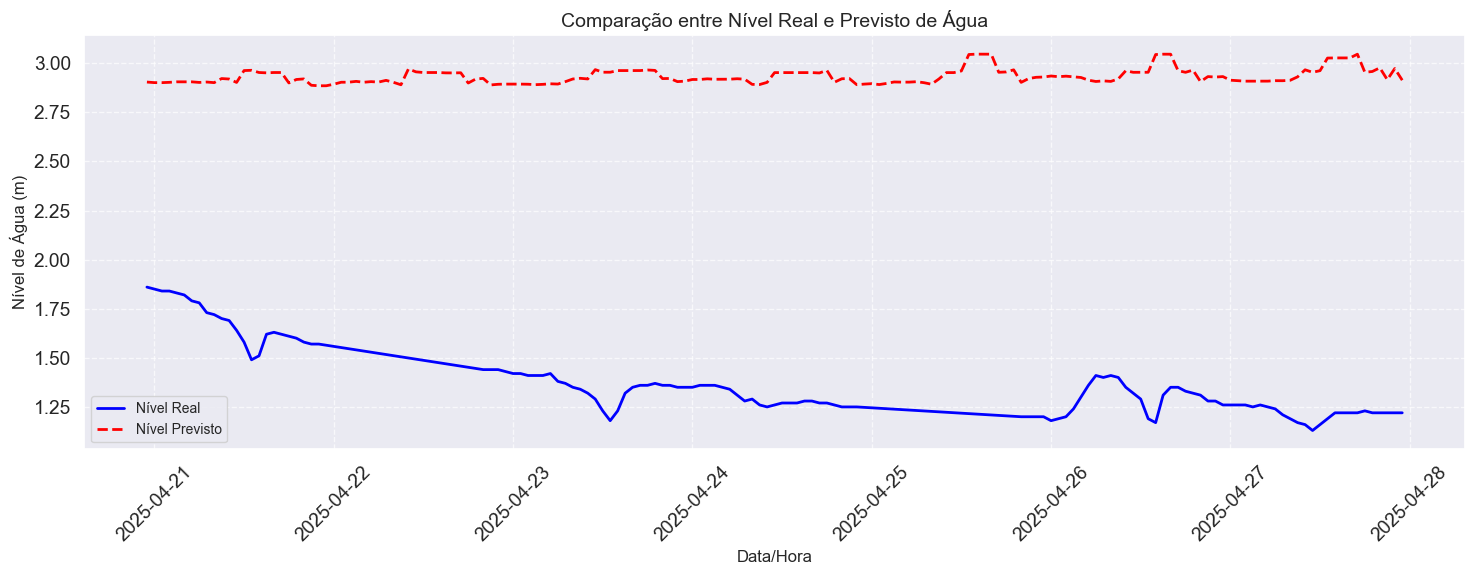

In [32]:
plt.figure(figsize=(15, 6))

plt.plot(predict_df['time'], predict_df['water_level_next_3h'], 
         label='Nível Real', linewidth=2, color='blue')

plt.plot(predict_df['time'], predict_df['predicted_water_level_next_3h'], 
         label='Nível Previsto', linewidth=2, color='red', linestyle='--')

plt.title('Comparação entre Nível Real e Previsto de Água', fontsize=14)
plt.xlabel('Data/Hora', fontsize=12)
plt.ylabel('Nível de Água (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()